# Stock Trend Barometer

### Extract S&P500 tickers from Wikipedia using pandas, use these to collect historic prices from Yahoo Finance and calculate multiple Technical Indicators over various time frames and determine the strength of a trend by aggregating these indicators

### Imports

In [1]:
import requests
import talib
import time
import math
import pickle
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from functools import wraps
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from matplotlib.dates import MO, AutoDateLocator, WeekdayLocator, MonthLocator
from yahoofinancials import YahooFinancials

### Timing decorator that will show how long the various functions take to run

In [2]:
def timethis(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        r = func(*args, **kwargs)
        end = time.perf_counter()
        print('{}.{} : {} milliseconds'.format(func.__module__, func.__name__, (end - start)*1e3))
        return r
    return wrapper

### Function to extract list of SPX tickers from Wikipedia

In [3]:
@timethis
def ticker_extract():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    r = requests.get(url)
    html_doc = r.text
    spx_list = pd.read_html(html_doc)

    # the first table on the page contains the stock data
    spx_table = spx_list[0]

    # create a list of the tickers from the 'Symbol' column
    tickers = list(spx_table['Symbol'])

    # create a dictionary mapping ticker to Security Name
    ticker_name_dict = dict(zip(spx_table['Symbol'],spx_table['Security']))
    ticker_short_name_dict = ticker_name_dict.copy()
    
    return tickers, ticker_name_dict, ticker_short_name_dict

In [4]:
tickers, ticker_name_dict, ticker_short_name_dict = ticker_extract()

__main__.ticker_extract : 701.4651000000001 milliseconds


In [5]:
print(tickers[:5])

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']


In [6]:
print(list(ticker_name_dict.items())[:5])

[('MMM', '3M Company'), ('ABT', 'Abbott Laboratories'), ('ABBV', 'AbbVie Inc.'), ('ABMD', 'ABIOMED Inc'), ('ACN', 'Accenture plc')]


### Function to extract historic prices from Yahoo Finance webpages

In [7]:
def chart_data_history(sym, start, end):
    
    # Suppress chained assignment warning that requests.get(url) triggers
    pd.set_option('mode.chained_assignment',None)
    
    print(sym)
    
    # Create DataFrame to collect all the history
    df_total = pd.DataFrame()
    
    # Convert string input dates to Datetime objects
    start_date = dt.datetime.strptime(start, "%Y/%m/%d")
    end_date = dt.datetime.strptime(end, "%Y/%m/%d")
    
    # To get round the limitation of only returning 100 days history we extract the data in batches of less than 100
    increment = 90
    
    # calculate the time window and convert this to days and then work out how many loops will be required to return
    # all the data
    length = end_date - start_date 
    num_days = abs(int(length.days))
    loops = math.ceil(num_days/increment)
    
    # the url represents dates in unix time and 1 day is represented as the number of seconds and we convert start 
    # and end dates to unix timestamps 
    unix_day = 24*60*60
    start_ts = int(dt.datetime.timestamp(dt.datetime.strptime(start, "%Y/%m/%d")))
    end_ts = int(dt.datetime.timestamp(dt.datetime.strptime(end, "%Y/%m/%d")))
   
    # set loop counter to 0
    loop = 0
    while loop < loops:
    
        # calculate the increment size window used for each loop and extract the history table
        start_window = str(start_ts + (increment * unix_day * loop))
        end_window = str(min(start_ts + (increment * unix_day * (loop + 1)), end_ts))
        url = 'https://finance.yahoo.com/quote/'+sym+'/history?period1='+start_window+'&period2='+end_window+'&interval=1d&filter=history&frequency=1d'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[0]
        
        # Check if there is any incomplete data (represented by text in the 'Open' column) and filter out these rows
        pattern = '[A-Za-z]'
        df['Test'] = df['Open'].str.contains(pattern)
        df = df[df['Test'] == False]
        
        # Convert Date to the index and sort
        df.Date = pd.to_datetime(df.Date)
        df = df.set_index(['Date'])
        df = df.sort_index()
        
        # remove test column
        df = df.drop(columns=('Test'))
        
        # convert all table values to numeric
        df = df.apply(pd.to_numeric)
        
        # rename 'Close*' column
        df = df.rename(columns={'Close*':'Close'})
        
        # concatenate this time window to the DataFrame used to collect all the history
        df_total = pd.concat([df_total, df])
        
        # move to next time window
        loop += 1
        
    # return the complete history DataFrame    
    return df_total

### Create function to extract a DataFrame for each item in list of tickers and store in a dictionary, referenced by ticker

In [8]:
@timethis
def import_data_yahoo(tickers, start, end, n=None):
    
     # Create empty dictionary and list
    ticker_dict = {}
    exceptions = []
    
    # Loop through the tickers
    for sym in tickers[:n]:
        
        # Attempt to return the data for given ticker
        try:
            ticker_dict[sym] = chart_data_history(sym, start, end)
        
        # If error, add to list of exceptions and move to next ticker
        except:
            print("Error with "+sym)
            exceptions = exceptions.append(sym)
            continue
            
    return ticker_dict, exceptions

### Select the first 5 tickers extracted from the Wikipedia page

In [9]:
td_1, except_1 = import_data_yahoo(tickers, '2019/07/22', '2020/08/25', 5)

MMM
ABT
ABBV
ABMD
ACN
__main__.import_data_yahoo : 14192.5035 milliseconds


In [10]:
print(list(td_1.items())[:5])

[('MMM',               Open    High     Low   Close  Adj Close**   Volume
Date                                                            
2019-07-22  172.81  175.21  172.13  174.64       166.84  2004400
2019-07-23  176.00  178.02  175.65  177.52       169.59  2360700
2019-07-24  176.93  180.29  176.26  179.42       171.41  3532300
2019-07-25  187.01  187.72  176.66  178.13       170.18  7362000
2019-07-26  177.63  178.39  170.57  173.98       166.21  4016100
...            ...     ...     ...     ...          ...      ...
2020-08-18  164.43  165.44  163.76  164.38       162.90  1519100
2020-08-19  164.94  165.69  163.78  163.97       162.49  2012800
2020-08-20  163.02  163.66  162.38  162.97       161.50  1990300
2020-08-21  160.93  162.69  160.74  161.71       161.71  2005600
2020-08-24  161.55  163.95  161.15  163.53       163.53  2604400

[280 rows x 6 columns]), ('ABT',               Open    High     Low   Close  Adj Close**   Volume
Date                                           

### Select 2 year price history for all the SPX stocks 

In [11]:
td_2, except_2 = import_data_yahoo(tickers, '2018/07/20', '2020/08/25', 20)

MMM
ABT
ABBV
ABMD
ACN
ATVI
Error with ATVI
ADBE
AMD
AAP
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALXN
ALGN
ALLE
__main__.import_data_yahoo : 108681.935 milliseconds


In [12]:
print(list(td_2.items())[:20])

[('MMM',               Open    High     Low   Close  Adj Close**   Volume
Date                                                            
2018-07-19  201.76  202.29  199.51  201.60       187.11  2616400
2018-07-20  199.33  202.95  198.25  201.95       187.44  2325400
2018-07-23  201.54  201.54  197.68  198.84       184.55  3269100
2018-07-24  192.94  202.19  190.57  200.68       186.26  8186500
2018-07-25  200.63  204.49  200.52  204.38       189.69  3345200
...            ...     ...     ...     ...          ...      ...
2020-08-18  164.43  165.44  163.76  164.38       162.90  1519100
2020-08-19  164.94  165.69  163.78  163.97       162.49  2012800
2020-08-20  163.02  163.66  162.38  162.97       161.50  1990300
2020-08-21  160.93  162.69  160.74  161.71       161.71  2005600
2020-08-24  161.55  163.95  161.15  163.53       163.53  2604400

[535 rows x 6 columns]), ('ABT',               Open    High     Low   Close  Adj Close**   Volume
Date                                           

### This method very slow so let's create a function using YahooFinancials to extract each DataFrame

In [13]:
@timethis
def return_data(ticker, start_date, end_date, freq='daily'):
    
    yahoo_financials = YahooFinancials(ticker)
        
    # Extract historic prices
    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)

    # Reformat columns
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'Date',
                             'open': 'Open',
                             'high': 'High',
                             'low': 'Low',
                             'close': 'Close',
                             'volume': 'Volume'}) \
            .loc[:, ['Date','Open','High','Low','Close','Volume']] \
            .set_index('Date')

    # Set Index to Datetime
    df.index = pd.to_datetime(df.index)

    return df

### Function to return a dictionary of time series for all the tickers we select and collect a list of exceptions

In [14]:
@timethis
def import_data_yahoo_financials(tickers, start, end, mkts=None):
    # Create empty dictionary and list
    ticker_dict = {}
    exceptions = []

    # Loop through the tickers
    for sym in tickers[:mkts]:

        # Attempt to return the data for given ticker
        try:
            ticker_dict[sym] = return_data(ticker=sym,
                                           start_date=start,
                                           end_date=end,
                                           freq='daily')

        # If error, try replacing '.' with '-' in ticker 
        except:
            try:
                sym = sym.replace('.','-')
                ticker_dict[sym] = return_data(ticker=sym,
                                               start_date=start,
                                               end_date=end,
                                               freq='daily')
            # If error, add to list of exceptions and move to next ticker
            except:                    
                print("Error with "+sym)
                exceptions.append(sym)
                continue

    return ticker_dict, exceptions

### Select a window of the past 2 years

In [15]:
ticker_dict_full, except_full = import_data_yahoo_financials(tickers, '2018-07-20', '2020-08-25')

__main__.return_data : 168.97199999999657 milliseconds
__main__.return_data : 170.85020000001805 milliseconds
__main__.return_data : 113.65309999996498 milliseconds
__main__.return_data : 103.47760000001927 milliseconds
__main__.return_data : 115.75850000002674 milliseconds
__main__.return_data : 108.6444999999685 milliseconds
__main__.return_data : 126.88670000000002 milliseconds
__main__.return_data : 104.78549999999132 milliseconds
__main__.return_data : 113.44509999997854 milliseconds
__main__.return_data : 157.5081999999952 milliseconds
__main__.return_data : 151.5770000000316 milliseconds
__main__.return_data : 118.26160000003938 milliseconds
__main__.return_data : 145.40759999999864 milliseconds
__main__.return_data : 104.42449999999326 milliseconds
__main__.return_data : 148.35750000003145 milliseconds
__main__.return_data : 141.3506999999754 milliseconds
__main__.return_data : 143.59839999997348 milliseconds
__main__.return_data : 104.52309999999443 milliseconds
__main__.retur

__main__.return_data : 122.11850000005597 milliseconds
__main__.return_data : 145.38250000003927 milliseconds
__main__.return_data : 110.0331999999753 milliseconds
__main__.return_data : 187.58200000002034 milliseconds
__main__.return_data : 94.2501999999763 milliseconds
__main__.return_data : 250.9139999999661 milliseconds
__main__.return_data : 183.4655999999768 milliseconds
__main__.return_data : 138.24819999996407 milliseconds
__main__.return_data : 147.25179999999227 milliseconds
__main__.return_data : 121.4998000000378 milliseconds
__main__.return_data : 198.67260000000897 milliseconds
__main__.return_data : 148.4555000000114 milliseconds
__main__.return_data : 246.60560000000942 milliseconds
__main__.return_data : 103.04559999997309 milliseconds
__main__.return_data : 133.90710000004447 milliseconds
__main__.return_data : 200.3001999999583 milliseconds
__main__.return_data : 116.14470000000665 milliseconds
__main__.return_data : 113.13699999999471 milliseconds
__main__.return_da

__main__.return_data : 110.31830000001719 milliseconds
__main__.return_data : 184.12960000000567 milliseconds
__main__.return_data : 141.63130000002866 milliseconds
__main__.return_data : 163.3367000000021 milliseconds
__main__.return_data : 135.60630000000629 milliseconds
__main__.return_data : 113.765600000022 milliseconds
__main__.return_data : 173.80120000001398 milliseconds
__main__.return_data : 121.4685999999574 milliseconds
__main__.return_data : 213.18140000005315 milliseconds
__main__.return_data : 140.95539999999573 milliseconds
__main__.return_data : 145.8013999999821 milliseconds
__main__.return_data : 221.83080000002064 milliseconds
__main__.return_data : 129.59079999995993 milliseconds
__main__.return_data : 106.2086000000022 milliseconds
__main__.return_data : 114.30870000003779 milliseconds
__main__.return_data : 106.9231999999829 milliseconds
__main__.return_data : 108.8004000000069 milliseconds
__main__.return_data : 138.96070000004102 milliseconds
__main__.return_da

__main__.return_data : 146.45930000000362 milliseconds
__main__.return_data : 148.5238999999865 milliseconds
__main__.return_data : 102.03279999996084 milliseconds
__main__.return_data : 202.64290000000074 milliseconds
__main__.return_data : 102.08919999996624 milliseconds
__main__.return_data : 114.14049999996223 milliseconds
__main__.return_data : 131.88860000002478 milliseconds
__main__.return_data : 102.65470000001642 milliseconds
__main__.return_data : 131.17119999998295 milliseconds
__main__.return_data : 119.44670000002588 milliseconds
__main__.return_data : 125.21580000003496 milliseconds
__main__.return_data : 128.54279999999108 milliseconds
__main__.return_data : 150.63730000002806 milliseconds
__main__.return_data : 141.4370999999619 milliseconds
__main__.return_data : 156.51850000000422 milliseconds
__main__.return_data : 141.97460000002593 milliseconds
__main__.return_data : 122.9483999999843 milliseconds
__main__.return_data : 103.74489999998104 milliseconds
__main__.retu

### Look at the exceptions

In [16]:
print(except_full)

[]


### Retry if any exceptions

In [17]:
ticker_dict_ex1, exception_1 = import_data_yahoo_financials(except_full, '2018-07-20', '2020-08-25')

__main__.import_data_yahoo_financials : 0.0026999999818144715 milliseconds


### Combine dictionaries

In [18]:
ticker_dict_full.update(ticker_dict_ex1)

### Store the dictionary in serialized form so as to be able to subsequently refer to the data without having to download again

In [19]:
with open('spx_2y.pickle', 'wb') as handle:
    pickle.dump(ticker_dict_full, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Reload the data as necessary

In [20]:
with open('spx_2y.pickle', 'rb') as handle:
    ticker_dict_full = pickle.load(handle)

### Take a look at the first 10 items in the dictionary

In [21]:
print(list(ticker_dict_full.items())[:10])

[('MMM',                   Open        High         Low       Close   Volume
Date                                                               
2018-07-20  199.330002  202.949997  198.250000  201.949997  2325400
2018-07-23  201.539993  201.539993  197.679993  198.839996  3269100
2018-07-24  192.940002  202.190002  190.570007  200.679993  8186500
2018-07-25  200.630005  204.490005  200.520004  204.380005  3345200
2018-07-26  204.889999  208.440002  204.649994  207.960007  2848300
...                ...         ...         ...         ...      ...
2020-08-18  164.429993  165.440002  163.759995  164.380005  1519100
2020-08-19  164.940002  165.690002  163.779999  163.970001  2012800
2020-08-20  163.020004  163.660004  162.380005  162.970001  1990300
2020-08-21  160.929993  162.690002  160.740005  161.710007  2005600
2020-08-24  161.550003  163.949997  161.149994  163.529999  2604400

[528 rows x 5 columns]), ('ABT',                   Open        High         Low       Close   Volume
Date 

### Lists of parameter values for each of the indicators to be calculated

In [22]:
df_ma_list = [10, 20, 30, 50, 200]
df_macd_params = [12, 26, 9]
df_adx_list = [14, 20, 50, 200]
df_ma_cross_list = [[10, 30], [20, 50], [50, 200]]
df_price_cross_list = [20, 50, 200]
df_rsi_list = [14]
df_atr_list = [14]

### Create function to add Moving Average, MACD, ADX, RSI, ATR indicators and trend flags too each dataframe based on whether shorter MA is above longer MA, price is above MA, ADX is above 25 and MACD Histogram is increasing

In [23]:
@timethis
def create_fields(ticker_dict, ma_list=df_ma_list, macd_params=df_macd_params, adx_list=df_adx_list, 
                  ma_cross_list=df_ma_cross_list, price_cross_list=df_price_cross_list, 
                  rsi_list=df_rsi_list , atr_list=df_atr_list):        

    # Loop through each ticker in ticker_dict
    for ticker, df in ticker_dict.items():
        # Create moving averages of 10, 20, 30, 50 and 200 day timeframes
        for tenor in ma_list:
            df['MA_'+str(tenor)] = df['Close'].rolling(window=str(tenor)+'D').mean()


        # Create MACD, Signal and Hist using default parameters of 12, 26, 9
        df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = talib.MACD(df['Close'], fastperiod=macd_params[0], slowperiod=macd_params[1], signalperiod=macd_params[2])
        # Create flag for MACD histogram increasing 
        df['MACD_flag'] = np.where(df['MACD_HIST'].diff() > 0, 1, 0)


        # Create ADX of 14, 20, 50 and 200 day timeframes 
        # Create flags for ADX over 25 for 20, 50 and 200 day timeframes
        for tenor in adx_list:
            df['ADX_'+str(tenor)] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=tenor)
            df['ADX_'+str(tenor)+'_flag'] = np.where(df['ADX_'+str(tenor)] > 25, 1, 0)


        # Create flag for fast moving average crossing slow moving average
        for tenor_pair in ma_cross_list:
            df['MA_'+str(tenor_pair[0])+'_'+str(tenor_pair[1])] = np.where(df['MA_'+str(tenor_pair[0])] > df['MA_'+str(tenor_pair[1])], 1, 0)


        # Create flag for price crossing moving average
        for tenor in price_cross_list:
            df['PX_MA_'+str(tenor)] = np.where(df['Close'] > df['MA_'+str(tenor)], 1, 0)


        # Create RSI with 14 day timeframe 
        for tenor in rsi_list:
            df['RSI_'+str(tenor)] = talib.RSI(df['Close'], timeperiod=tenor)

        # Create Average True Range with 14 day timeframe
        for tenor in atr_list:
            df['ATR_'+str(tenor)] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=tenor)


    return ticker_dict

### Function to create new dataframe showing whether the indicators are showing atrending situation for each of the securities

In [24]:
@timethis
def create_barometer(ticker_dict, ticker_name_dict, trend_flags):
    
    # Create list of tickers from ticker_dict
    ticker_list = [ticker for ticker, df in ticker_dict.items()]

    # Convert ticker_name_dict to DataFrame 
    ticker_name_df = pd.DataFrame.from_dict(ticker_name_dict, orient='index', columns=['Long_name']) 

    # Create empty DataFrame with Trend Flags as columns and tickers as rows
    frame = pd.DataFrame(columns = trend_flags, index = ticker_list)

    # Merge the two DataFrames
    frame = pd.merge(frame, ticker_name_df, left_index=True, right_index=True)

    # Reorder columns with list of column names moving the Long Name to the start 
    cols = [frame.columns[-1]] + [col for col in frame if col != frame.columns[-1]]
    frame = frame[cols]

    # Loop through each ticker in ticker_dict to populate trend flags in frame
    for ticker, df in ticker_dict.items():
        for flag in trend_flags:
            frame.loc[ticker, flag] = df[flag].iloc[-1]

    # Create trend strength column that sums the trend flags and sort by this column       
    frame['Trend Strength'] = frame.iloc[:,1:].sum(axis=1)
    frame = frame.sort_values(by=['Trend Strength'], ascending=False)

    # Create short name column, stripping text from longname 
    frame['Short_name'] = frame.loc[:,'Long_name'].str.replace('Continuous Futures Backadjusted','')

    return frame


### List of trend flags to compare, ordered from short term to long term 

In [25]:
trend_flags = ['MA_10_30',
               'MACD_flag',               
               'PX_MA_20',
               'MA_20_50',
               'ADX_20_flag',
               'PX_MA_50',
               'MA_50_200',
               'ADX_50_flag',
               'PX_MA_200',
               'ADX_200_flag']

### Create Trend Barometer using the list of SPX tickers

In [26]:
ticker_dict_full = create_fields(ticker_dict_full)
barometer = create_barometer(ticker_dict_full, ticker_name_dict, trend_flags)

__main__.create_fields : 7100.341200000003 milliseconds
__main__.create_barometer : 716.40960000002 milliseconds


In [27]:
barometer.head(15)

,Long_name,MA_10_30,MACD_flag,PX_MA_20,MA_20_50,ADX_20_flag,PX_MA_50,MA_50_200,ADX_50_flag,PX_MA_200,ADX_200_flag,Trend Strength,Short_name
AAPL,Apple Inc.,1,1,1,1,1,1,1,1,1,0,9.0,Apple Inc.
AMZN,Amazon.com Inc.,1,1,1,1,1,1,1,1,1,0,9.0,Amazon.com Inc.
ROL,Rollins Inc.,1,1,1,1,1,1,1,1,1,0,9.0,Rollins Inc.
CARR,Carrier Global,1,1,1,1,1,1,1,1,1,0,9.0,Carrier Global
LKQ,LKQ Corporation,1,1,1,1,1,1,1,0,1,0,8.0,LKQ Corporation
FDX,FedEx Corporation,1,1,1,1,1,1,1,0,1,0,8.0,FedEx Corporation
PHM,PulteGroup,1,1,1,1,1,1,1,0,1,0,8.0,PulteGroup
CE,Celanese,1,1,1,1,1,1,1,0,1,0,8.0,Celanese
QCOM,QUALCOMM Inc.,1,1,1,1,1,1,1,0,1,0,8.0,QUALCOMM Inc.
UPS,United Parcel Service,1,0,1,1,1,1,1,1,1,0,8.0,United Parcel Service


### Function to create barchart of most / least trending markets

In [28]:
def trend_barchart(barometer=barometer, mkts=20, top=True):
    
    # Initialize the figure
    fig, ax = plt.subplots()

    # Set the xticks to be integer values
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set the yticks to be horizontal
    plt.yticks(rotation=0)

    # If the markets flag is set to False, show the markets with lowest trend indication
    if top == False:
        plt.barh(barometer['Short_name'][-mkts:], barometer['Trend Strength'][-mkts:])

    # Otherwise show the markets with greatest trend indication 
    else:
        plt.barh(barometer['Short_name'][:mkts], barometer['Trend Strength'][:mkts])

    # Label xaxis
    plt.xlabel("Trend Strength") 

    plt.tight_layout()
    plt.show()


### Express the Top 20 results in a horizontal barchart

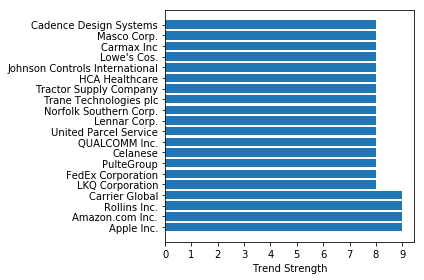

In [29]:
trend_barchart(mkts=20)

### And the Bottom 20

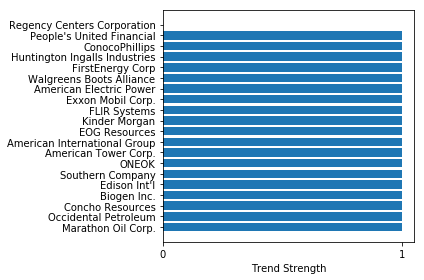

In [30]:
trend_barchart(mkts=20, top=False)

 ### Function to create list of Top and/or Bottom trending markets and new dataframe of the closing prices of these markets and forward fill prices to fill in any NaN values

In [31]:
def prepare_chart_data(barometer, ticker_dict, ticker_short_name_dict, mkts=5, up='Both'):
    
    # if trend flag is True, select tickers of most trending markets (twice 
    # as many as if selecting both)
    if up == True:
        data_list = list(barometer.index[:(mkts*2)])

    # if trend flag is False, select tickers of least trending markets        
    elif up == False:
        data_list = list(barometer.index[-(mkts*2):])

    # Otherwise select both
    else:    
        top = list(barometer.index[:mkts])
        bottom = list(barometer.index[-mkts:])
        data_list = top + bottom

    # Create a new DataFrame
    chart_data = pd.DataFrame()

    # For each ticker in the list of selected tickers, add the column of closing 
    # prices to new DataFrame
    for ticker in data_list:
        chart_data[ticker] = ticker_dict[ticker]['Close']

    # Rename columns from tickers to short names and forward fill any NaN cells
    chart_data = chart_data.rename(columns=ticker_short_name_dict)
    chart_data = chart_data.fillna(method='ffill')

    return chart_data, data_list

In [32]:
chart_data, data_list = prepare_chart_data(barometer, ticker_dict_full, ticker_short_name_dict, 5, 'Both')

### Function to normalize data histories to start from 100

In [33]:
def norm_hist(chart_data, days=60):
    
    # Copy the selected number of days history from the input DataFrame
    tenor = chart_data[-days:].copy()

    # Normalize the closing price of each ticker to start from 100 at the beginning of the history window
    for ticker in tenor.columns:
        tenor[ticker] = tenor[ticker].div(tenor[ticker].iloc[0]).mul(100) 

    return tenor  


### Normalized dataframes covering the past 1y, 6m and 3m

In [34]:
data_norm_3m = norm_hist(chart_data, 60) 
data_norm_6m = norm_hist(chart_data, 120) 
data_norm_1y = norm_hist(chart_data, 250)

### Function to graph returns

In [35]:
def return_graph(tenor):
    
    # Initialize the figure
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(16,8))

    # Plot the lineplot
    ax.plot(tenor)

    # axis formatting
    # create a variable to choose interval between xticks based on length of history
    week_scaler = int(round(len(tenor) / 30))
    month_scaler = int(round(len(tenor) / 120))

    # Set major xticks as every 4th Monday or monthly at a specified interval
    #major_tick = WeekdayLocator(byweekday=MO, interval = 4)
    scale_week_tick = WeekdayLocator(byweekday=MO, interval=week_scaler)
    scale_month_tick = MonthLocator(interval=month_scaler)
    #auto_date = AutoDateLocator(maxticks=6)

    # Set axis format as DD-MMM-YYYY or MMM-YYYY
    daysFmt = mdates.DateFormatter('%d-%b-%Y')
    monthsFmt = mdates.DateFormatter('%b-%Y')

    # If less than 90 days history use day format and locate major xticks on 4th Monday
    if len(tenor) < 90:
        ax.xaxis.set_major_formatter(daysFmt)
        ax.xaxis.set_major_locator(scale_week_tick)
        #ax.xaxis.set_major_locator(auto_date)
        #ax.xaxis.set_major_locator(major_tick)

    # Otherwise use month format and locate major xticks at monthly (or greater) intervals
    else:
        ax.xaxis.set_major_formatter(monthsFmt)
        ax.xaxis.set_major_locator(scale_month_tick)

    # Set minor xticks to be 4 within each major xtick
    minor_tick = AutoMinorLocator(4)
    ax.xaxis.set_minor_locator(minor_tick)

    # Set size of ticks
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

    # Set prices to the right as we are concerned with the current level
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()

    # Set the legend 
    plt.legend(loc='upper left', labels=tenor.columns)

    # Set xtick labels at 70 degrees
    plt.xticks(rotation=70)

    plt.tight_layout()
    plt.show()    


### 3 Month Returns of top and bottom 5 trending markets

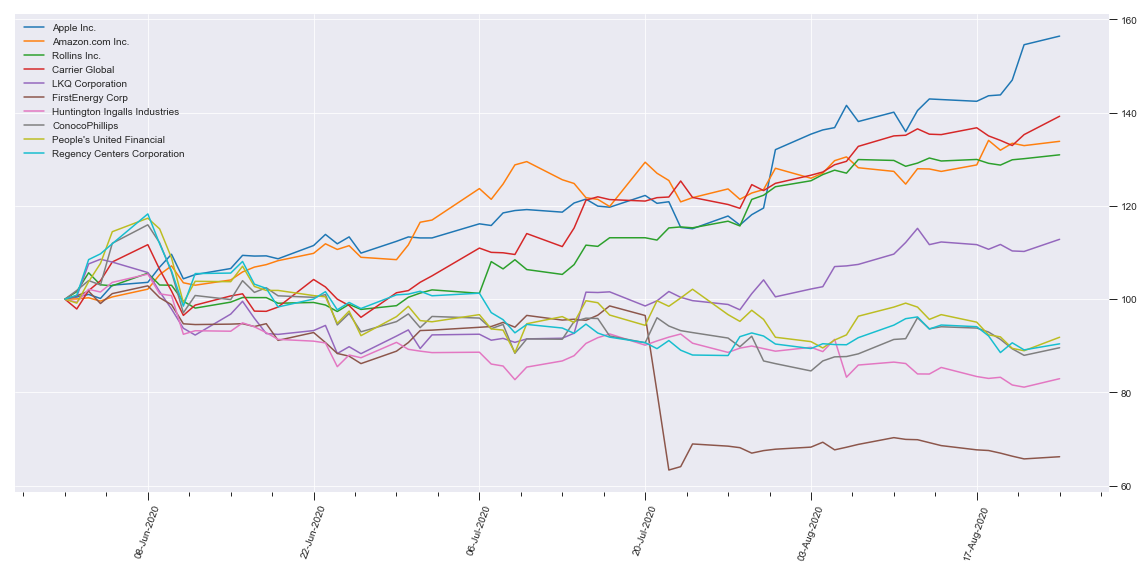

In [36]:
return_graph(data_norm_3m)

### 6 Month Returns of top and bottom 5 trending markets

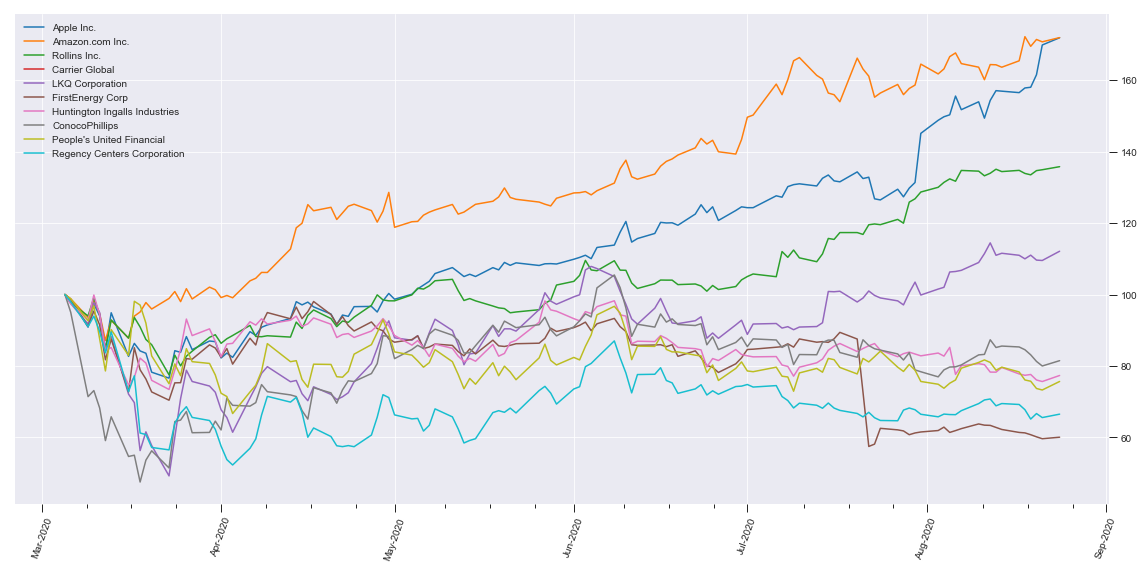

In [37]:
return_graph(data_norm_6m)

### 1 Year Returns of top and bottom 5 trending markets

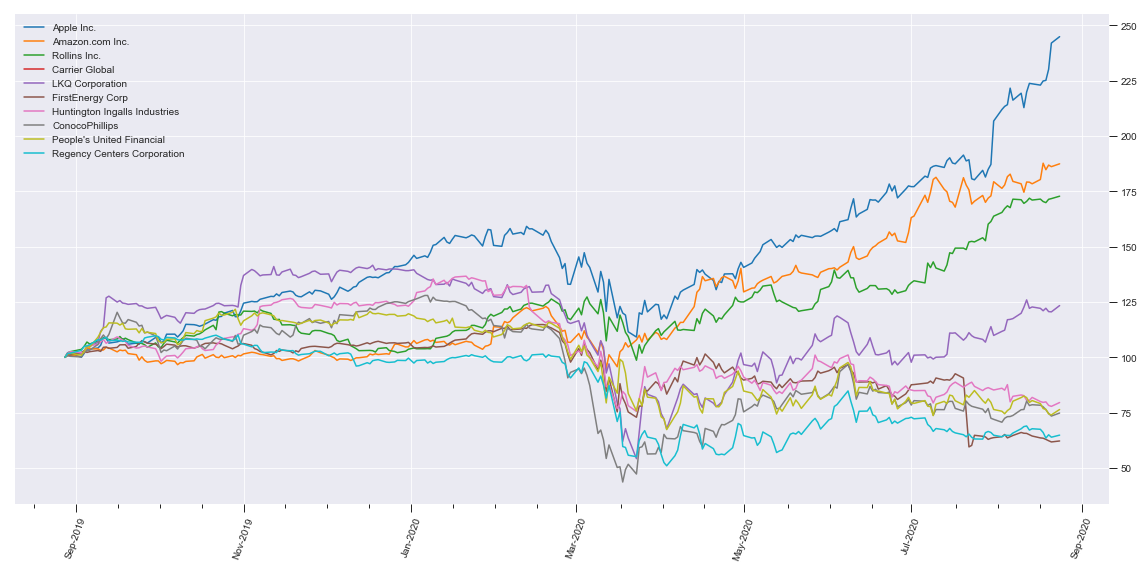

In [38]:
return_graph(data_norm_1y)

### Lets take a more granular look at the top and bottom 20

In [39]:
chart_data, data_list = prepare_chart_data(barometer, ticker_dict_full, ticker_short_name_dict, 20, 'Both')

### Function to plot comparison of 40 stocks

In [40]:
def market_chart(ticker_dict, ticker_short_name_dict, data_list, days=60, norm=True): 
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(16,16))
    plt.tight_layout()
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('tab20')

    # multiple line plot
    num=0
    for ticker in data_list:
        num += 1
        if num < 21:
            colr = num
        else:
            colr = num - 20

        label = ticker_short_name_dict[ticker]

        # Find the right spot on the plot
        ax = plt.subplot(8,5, num)

        # Plot the lineplot
        if norm == True:
            ax.plot(ticker_dict[ticker].index[-days:], 
                     ticker_dict[ticker]['Close'][-days:].div(ticker_dict[ticker]['Close'][-days:].iloc[0]).mul(100), 
                     marker='', 
                     color=palette(colr), 
                     linewidth=1.9, 
                     alpha=0.9, 
                     label=label)
        else:
            ax.plot(ticker_dict[ticker].index[-days:], 
                     ticker_dict[ticker]['Close'][-days:], 
                     marker='', 
                     color=palette(colr), 
                     linewidth=1.9, 
                     alpha=0.9, 
                     label=label)    

        # xticks only on bottom graphs
        if num in range(36) :
            plt.tick_params(labelbottom=False)

        # Add title
        plt.title(label, loc='left', fontsize=12, fontweight=0, color='black' )

        # axis formatting
        # create a variable to choose interval between xticks based on length of history
        week_scaler = int(round(days / 30))
        month_scaler = int(round(days / 120))

        # Set major xticks as every 4th Monday or monthly at a specified interval  
        #major_tick = WeekdayLocator(byweekday=MO, interval = 4)
        scale_week_tick = WeekdayLocator(byweekday=MO, interval=week_scaler)
        scale_month_tick = MonthLocator(interval=month_scaler)
        #auto_date = AutoDateLocator(maxticks=6)

        # Set axis format as DD-MMM-YYYY or MMM-YYYY
        daysFmt = mdates.DateFormatter('%d-%b-%Y')
        monthsFmt = mdates.DateFormatter('%b-%Y')

        # If less than 90 days history use day format and locate major xticks on 4th Monday
        if days < 90:
            ax.xaxis.set_major_formatter(daysFmt)
            #ax.xaxis.set_major_locator(auto_date)
            ax.xaxis.set_major_locator(scale_week_tick)
            #ax.xaxis.set_major_locator(major_tick)

        # Otherwise use month format and locate major xticks at monthly (or greater) intervals    
        else:
            ax.xaxis.set_major_formatter(monthsFmt)
            ax.xaxis.set_major_locator(scale_month_tick)

        # Set minor xticks to be 4 within each major xtick
        minor_tick = AutoMinorLocator(4)
        ax.xaxis.set_minor_locator(minor_tick)

        # Set size of ticks
        ax.tick_params(which='both', width=1)
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=4)

        # Set prices to the right as we are concerned with the current level
        ax.yaxis.set_label_position('right')
        ax.yaxis.tick_right()

        # Set xtick labels at 70 degrees
        plt.xticks(rotation=70)

    # general title
    plt.suptitle("Top and Bottom Trending Markets", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

### 3m Returns for each of the top and bottom 20 trending stocks - normalised

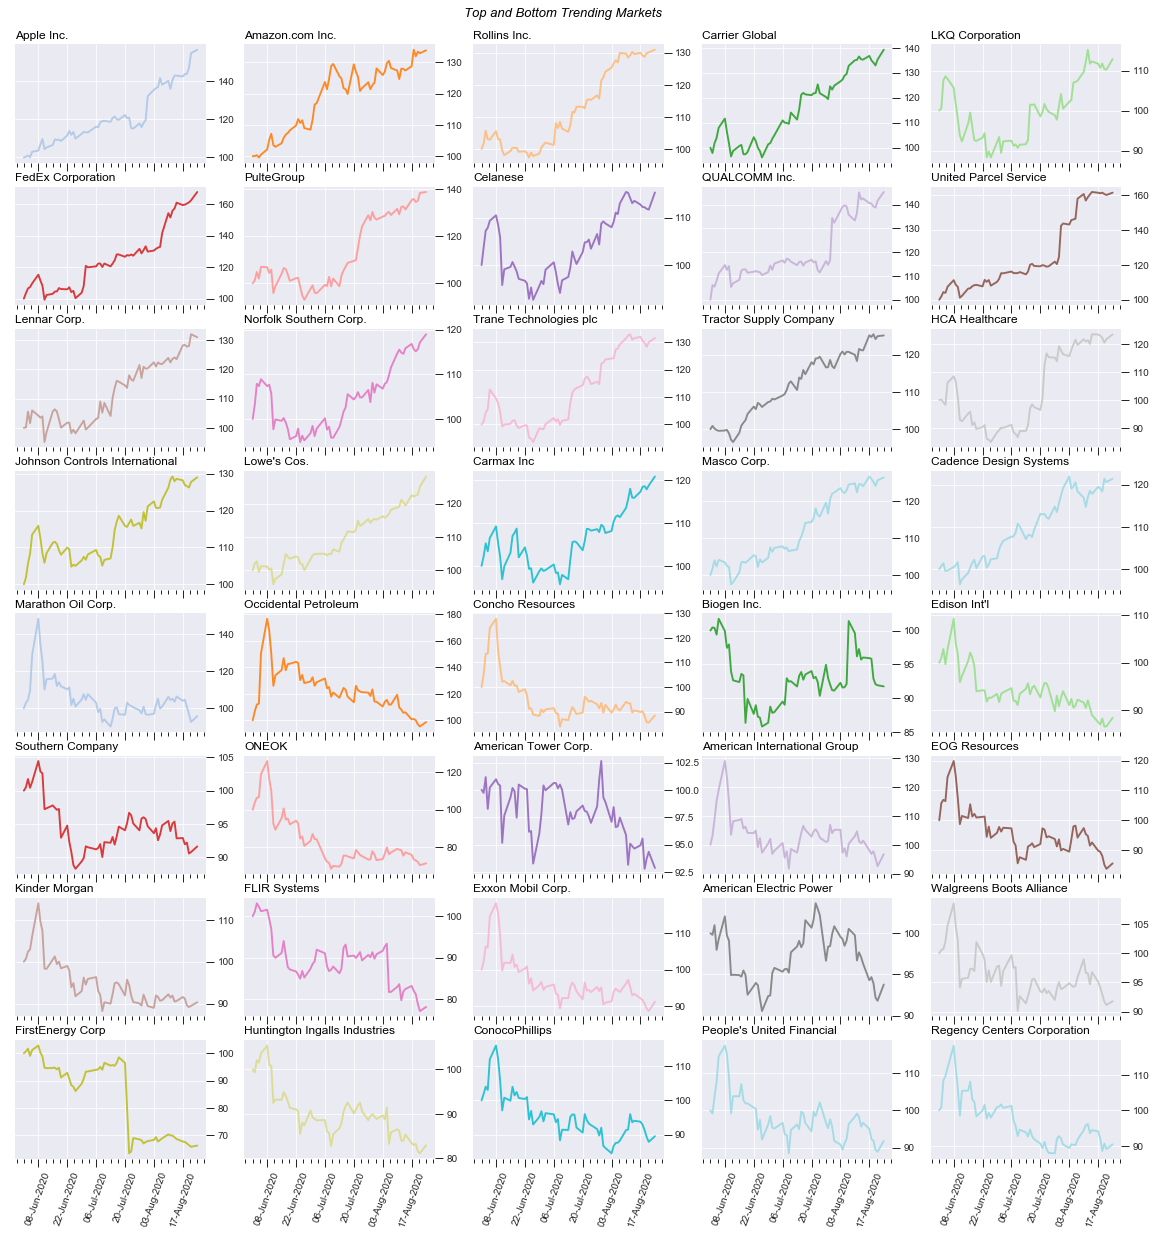

In [41]:
market_chart(ticker_dict_full, ticker_short_name_dict, data_list, 60, True)

### 3m Returns for each of the top and bottom 20 trending stocks - non-normalised

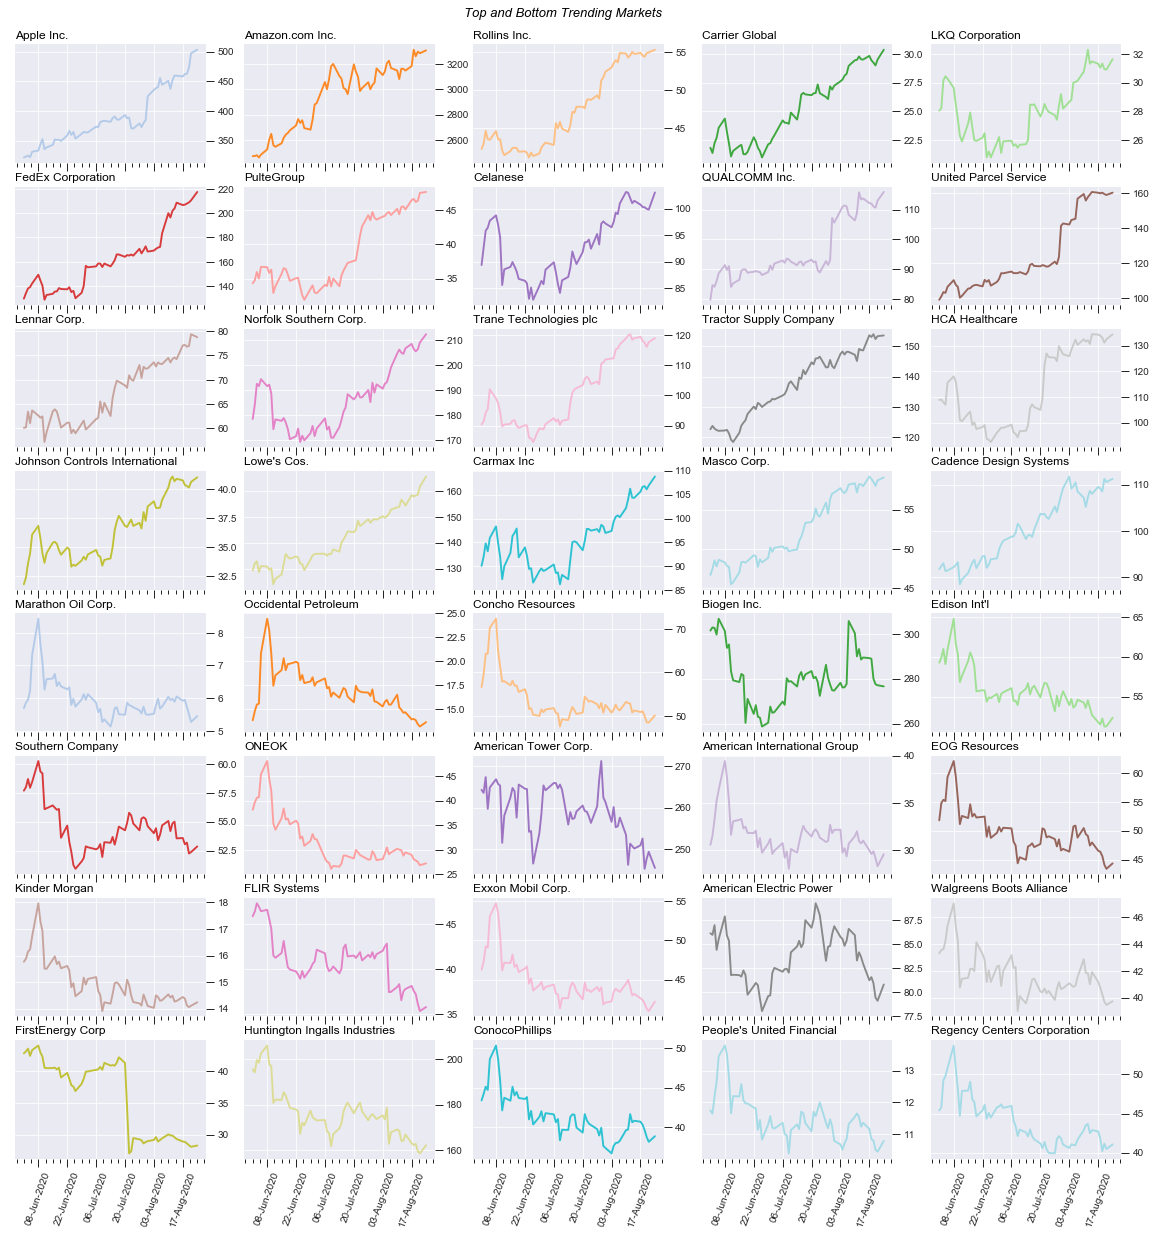

In [42]:
market_chart(ticker_dict_full, ticker_short_name_dict, data_list, 60, False)

### 1y Returns for each of the top and bottom 20 trending stocks - normalised

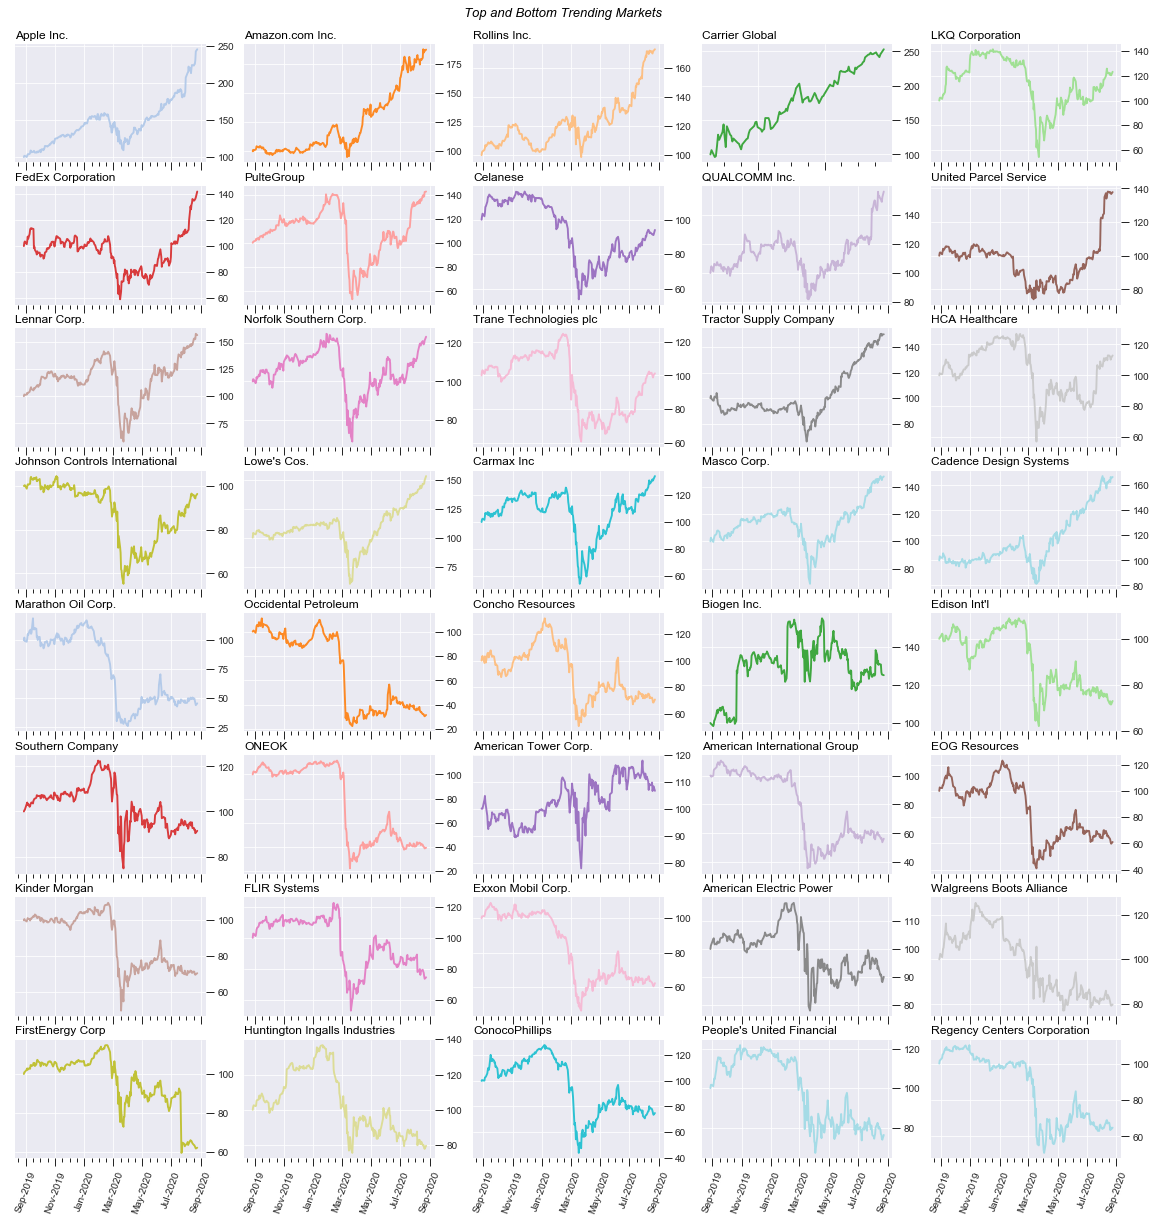

In [43]:
market_chart(ticker_dict_full, ticker_short_name_dict, data_list, 250, True)

### 1y Returns for each of the top and bottom 20 trending stocks - non-normalised

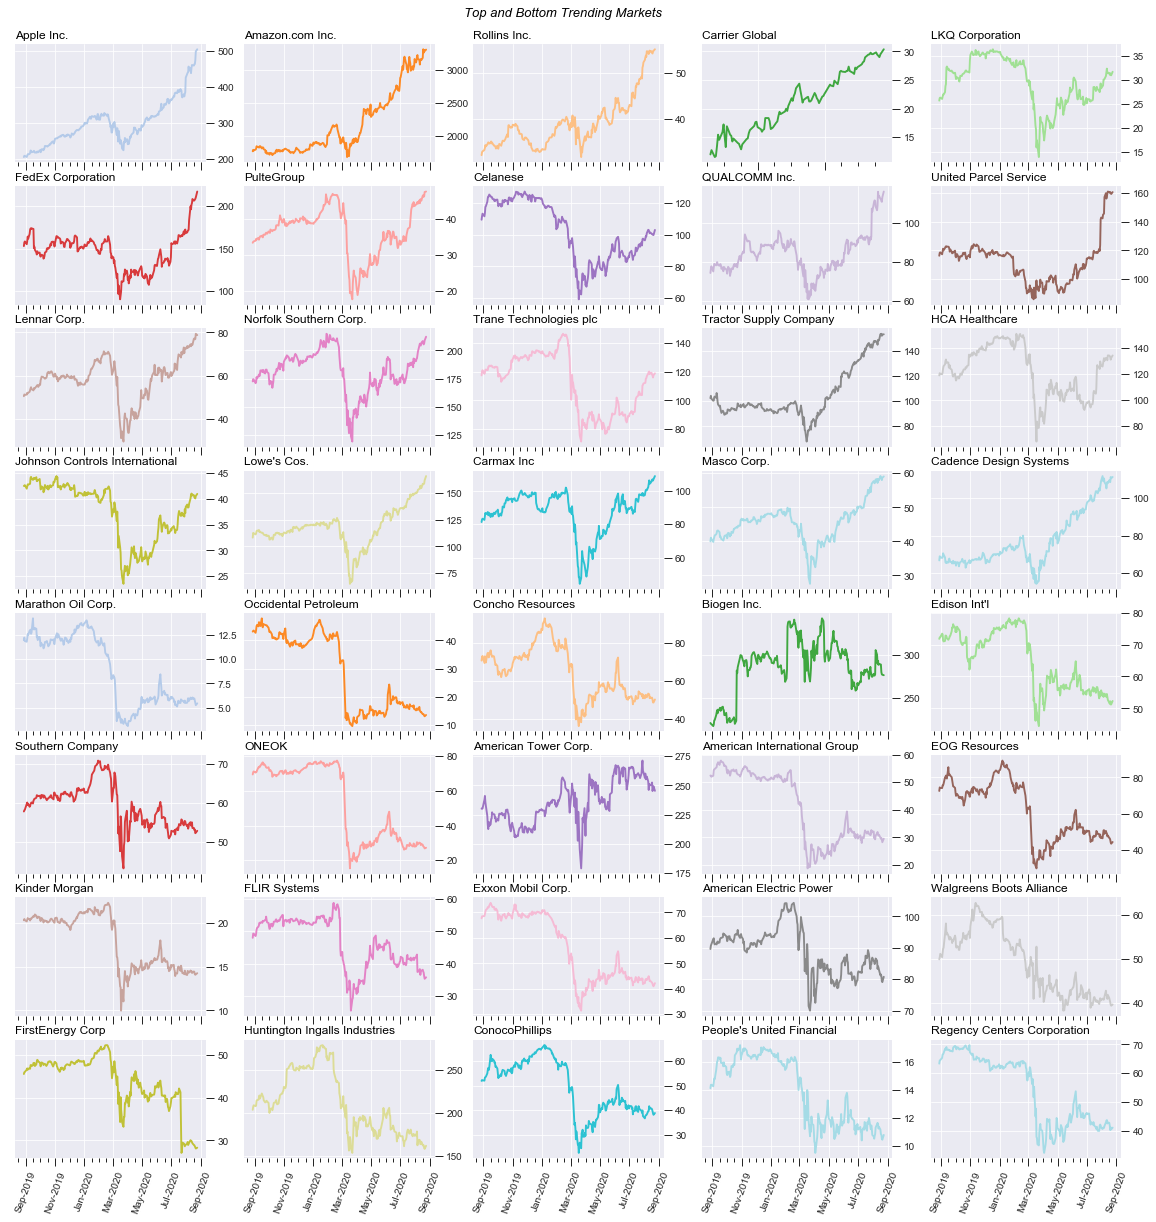

In [44]:
market_chart(ticker_dict_full, ticker_short_name_dict, data_list, 250, False)